In [1]:
import pandas as pd
import os
import numpy as np
from ast import literal_eval
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

random.seed(42)

In [2]:
# Readging the csv 

train = pd.read_csv("data/train.csv")
val = pd.read_csv("data/val.csv")
submission = pd.read_csv("data/sample_submission.csv")

train

,embeddings,label
0,"[0.3206779360771179, 0.988215982913971, 1.0441...",positive
1,"[0.05074610561132431, 1.0742985010147095, 0.60...",negative
2,"[0.41962647438049316, 0.4505457878112793, 1.39...",negative
3,"[0.4361684024333954, 0.19191382825374603, 0.83...",positive
4,"[0.6382085084915161, 0.8352395296096802, 0.393...",neutral
...,...,...
4995,"[2.2057647705078125, 1.1072001457214355, 0.435...",neutral
4996,"[0.6344252228736877, 1.164398193359375, 0.7155...",negative
4997,"[0.9160683155059814, 0.39996421337127686, 0.82...",negative
4998,"[0.006456990726292133, 0.18667978048324585, 0....",positive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [4]:
# Getting the feature and labels from each set. 


X = np.array([literal_eval(embedding)  for embedding in train['embeddings'].values])
y = np.array(train['label'].values)

X_val = np.array([literal_eval(embedding)  for embedding in val['embeddings'].values])
y_val = np.array(val['label'].values)

In [5]:
X.shape, y.shape, X_val.shape, y.shape

((5000, 512), (5000,), (2000, 512), (5000,))

In [6]:
mean = np.mean(X,axis=0)
std = np.std(X,axis=0)

<ErrorbarContainer object of 3 artists>

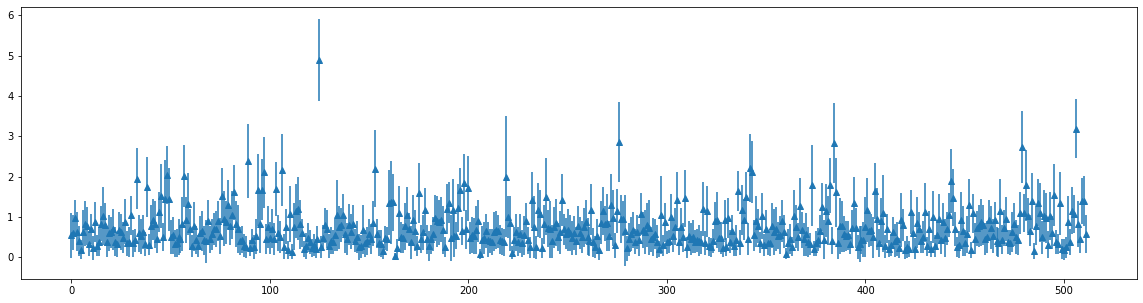

In [7]:
plt.figure(figsize=(20,5))
plt.errorbar(range(512), mean, std, linestyle='None', marker='^')

In [8]:
y[y=='positive']=2
y[y=='negative']=0
y[y=='neutral']=1

y_val[y_val=='positive']=2
y_val[y_val=='negative']=0
y_val[y_val=='neutral']=1

y=y.astype(np.int32)
y_val=y_val.astype(np.int32)

In [9]:
y[:10]

array([2, 0, 0, 2, 1, 0, 0, 0, 2, 0], dtype=int32)

In [10]:
np.unique(y, return_counts=True)

(array([0, 1, 2], dtype=int32), array([1622, 1694, 1684]))

In [11]:
np.unique(y_val, return_counts=True)

(array([0, 1, 2], dtype=int32), array([640, 633, 727]))

In [12]:
def normalize_X(X):
    return (X-mean)/std

In [13]:
tx = torch.Tensor(normalize_X(X))
ty = torch.Tensor(y).long()

tx_val = torch.Tensor(normalize_X(X_val))
ty_val = torch.Tensor(y_val).long()

ds_train = TensorDataset(tx,ty)
# train_loader = DataLoader(ds_train, batch_size=1000)

ds_val = TensorDataset(tx_val,ty_val)
# val_loader = DataLoader(ds_val, batch_size=1000)

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(use_cuda,device)

True cuda


In [15]:
from tqdm import tqdm

In [16]:
from livelossplot import PlotLosses


In [17]:
epochs=10000
batch_size=5000

criterion = nn.CrossEntropyLoss()#label_smoothing=0.1)

class NetDDD3(nn.Module):
    def __init__(self):
        super(NetDDD3, self).__init__()
        self.m = nn.Sequential(nn.Linear(512, 2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,3))

    def forward(self, x):
        return self.m(x)
    
class NetDDD2(nn.Module):
    def __init__(self):
        super(NetDDD2, self).__init__()
        self.m = nn.Sequential(nn.Linear(512, 5000),
                                   nn.ReLU(),
                                   nn.Linear(5000,5000),
                                   nn.ReLU(),
                                   nn.Linear(5000,5000),
                                   nn.ReLU(),
                                   nn.Linear(5000,5000),
                                   nn.ReLU(),
                                   nn.Linear(5000,5000),
                                   nn.ReLU(),
                                   nn.Linear(5000,3))

    def forward(self, x):
        return self.m(x)

class NetDDD(nn.Module):
    def __init__(self):
        super(NetDDD, self).__init__()
        self.m = nn.Sequential(nn.Linear(512, 2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,3))

    def forward(self, x):
        return self.m(x)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.m1 = nn.Sequential(nn.Linear(512, 2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,256),
                                   nn.ReLU(),
                                   nn.Dropout(0.3),
                                   nn.Linear(256,3))
        
        self.m2 = nn.Sequential(nn.Linear(512, 256),
                                   nn.ReLU(),
                                   nn.Linear(256,3))
        self.m3 = nn.Sequential(nn.Linear(512, 3))

        
        self.m4 = nn.Sequential(nn.Linear(512, 2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,256),
                                   nn.ReLU(),
                                   nn.Dropout(0.3),
                                   nn.Linear(256,3))
        
        self.m5 = nn.Sequential(nn.Linear(512, 2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,256),
                                   nn.ReLU(),
                                   nn.Dropout(0.8),
                                   nn.Linear(256,3))

        self.fc = nn.Linear(3*5,3)

    def forward(self, x):
        a = torch.cat((self.m1(x),self.m2(x),self.m3(x),self.m4(x),self.m5(x)),1)
        return self.fc(nn.Dropout(0.3)(nn.ReLU()(a)))

# model = NetDDD3().to(device)
# lr = 3e-2
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)


# train_losses=[]
# val_losses=[]
# train_accs=[]
# val_accs=[]

# liveloss = PlotLosses()

# for epoch in range(1, epochs + 1):
#     model.train()
#     train_loss=0
#     correct=0
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()
# #         scheduler.step()
        
#         pred = output.argmax(dim=1, keepdim=True)
#         correct += pred.eq(target.view_as(pred)).sum().item()
#         train_loss+=loss.item()
#     train_loss/=len(train_loader)
#     acc = correct / len(train_loader.dataset)
#     train_losses.append(train_loss)
#     train_accs.append(acc)
    
#     model.eval()
#     val_loss = 0
#     correct = 0
#     val_f1 = 0
#     with torch.no_grad():
#         for data, target in val_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             vl=criterion(output, target).item()
#             val_loss += vl
#             pred = output.argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()
            
#             val_f1+=f1_score(target.view_as(pred).cpu(), pred.cpu(), average='weighted')
        

#     val_loss /= float(len(val_loader))
#     val_acc = correct / len(val_loader.dataset)
#     val_losses.append(val_loss)
#     val_accs.append(val_acc)
    
#     val_f1 /= float(len(val_loader))
    
#     logs={}
#     logs['train_loss'] = train_loss
#     logs['val_loss'] = val_loss
#     logs['train_acc'] = acc
# #     logs['val_acc'] = val_acc
#     logs['val_f1'] = val_f1
    
#     liveloss.update(logs)
#     if epoch%5==0:
#         liveloss.send()
# #     if epoch%10==0:
# #         print("Epoch %3d Train loss: %f Acc: %f    Val loss: %f Acc: %f"%(epoch, train_loss, acc, val_loss, val_acc))
# plt.figure(figsize=(20,10))
# plt.subplot(1,2,1)
# plt.plot(train_losses, label='train loss')
# plt.plot(val_losses, label='val loss')
# plt.legend();
# plt.subplot(1,2,2)
# plt.plot(train_accs, label='train acc')
# plt.plot(val_accs, label='val acc')
# plt.legend();
# # plt.ylim(0,1);

In [18]:
# epochs=100
# batch_size=5000

# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# model = NetDDD3().to(device)
# lr = 1e-1
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)


# train_losses=[]
# val_losses=[]
# train_accs=[]
# val_accs=[]
# val_f1s = []

# liveloss = PlotLosses()

# for epoch in range(1, epochs + 1):
#     model.train()
#     train_loss=0
#     correct=0
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()
#         scheduler.step()
        
#         pred = output.argmax(dim=1, keepdim=True)
#         correct += pred.eq(target.view_as(pred)).sum().item()
#         train_loss+=loss.item()
#     train_loss/=len(train_loader)
#     acc = correct / len(train_loader.dataset)
#     train_losses.append(train_loss)
#     train_accs.append(acc)
    
#     model.eval()
#     val_loss = 0
#     correct = 0
#     val_f1 = 0
#     with torch.no_grad():
#         for data, target in val_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             vl=criterion(output, target).item()
#             val_loss += vl
#             pred = output.argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()
            
#             val_f1+=f1_score(target.view_as(pred).cpu(), pred.cpu(), average='weighted')
        

#     val_loss /= float(len(val_loader))
#     val_acc = correct / len(val_loader.dataset)
#     val_losses.append(val_loss)
#     val_accs.append(val_acc)
    
    
#     val_f1 /= float(len(val_loader))
#     val_f1s.append(val_f1)
    
#     logs={}
#     logs['train_loss'] = train_loss
#     logs['val_loss'] = val_loss
#     logs['train_acc'] = acc
# #     logs['val_acc'] = val_acc
#     logs['val_f1'] = val_f1
    
#     liveloss.update(logs)
#     if epoch%5==0:
#         liveloss.send()
# #     if epoch%10==0:
# #         print("Epoch %3d Train loss: %f Acc: %f    Val loss: %f Acc: %f"%(epoch, train_loss, acc, val_loss, val_acc))
# plt.figure(figsize=(20,10))
# # plt.subplot(1,2,1)
# # plt.plot(train_losses, label='train loss')
# # plt.plot(val_losses, label='val loss')
# # plt.legend();
# # plt.subplot(1,2,2)
# # plt.plot(train_accs, label='train acc')
# # plt.plot(val_accs, label='val acc')
# plt.plot(val_accs, label='val f1')
# plt.legend();
# # plt.ylim(0,1);

In [19]:

from typing import Iterable, Optional
import weakref
import copy
import contextlib

import torch


# Partially based on:
# https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/python/training/moving_averages.py
class ExponentialMovingAverage:
    """
    Maintains (exponential) moving average of a set of parameters.
    Args:
        parameters: Iterable of `torch.nn.Parameter` (typically from
            `model.parameters()`).
            Note that EMA is computed on *all* provided parameters,
            regardless of whether or not they have `requires_grad = True`;
            this allows a single EMA object to be consistantly used even
            if which parameters are trainable changes step to step.
            If you want to some parameters in the EMA, do not pass them
            to the object in the first place. For example:
                ExponentialMovingAverage(
                    parameters=[p for p in model.parameters() if p.requires_grad],
                    decay=0.9
                )
            will ignore parameters that do not require grad.
        decay: The exponential decay.
        use_num_updates: Whether to use number of updates when computing
            averages.
    """
    def __init__(
        self,
        parameters: Iterable[torch.nn.Parameter],
        decay: float,
        use_num_updates: bool = True
    ):
        if decay < 0.0 or decay > 1.0:
            raise ValueError('Decay must be between 0 and 1')
        self.decay = decay
        self.num_updates = 0 if use_num_updates else None
        parameters = list(parameters)
        self.shadow_params = [
            p.clone().detach()
            for p in parameters
        ]
        self.collected_params = None
        # By maintaining only a weakref to each parameter,
        # we maintain the old GC behaviour of ExponentialMovingAverage:
        # if the model goes out of scope but the ExponentialMovingAverage
        # is kept, no references to the model or its parameters will be
        # maintained, and the model will be cleaned up.
        self._params_refs = [weakref.ref(p) for p in parameters]

    def _get_parameters(
        self,
        parameters: Optional[Iterable[torch.nn.Parameter]]
    ) -> Iterable[torch.nn.Parameter]:
        if parameters is None:
            parameters = [p() for p in self._params_refs]
            if any(p is None for p in parameters):
                raise ValueError(
                    "(One of) the parameters with which this "
                    "ExponentialMovingAverage "
                    "was initialized no longer exists (was garbage collected);"
                    " please either provide `parameters` explicitly or keep "
                    "the model to which they belong from being garbage "
                    "collected."
                )
            return parameters
        else:
            parameters = list(parameters)
            if len(parameters) != len(self.shadow_params):
                raise ValueError(
                    "Number of parameters passed as argument is different "
                    "from number of shadow parameters maintained by this "
                    "ExponentialMovingAverage"
                )
            return parameters

    def update(
        self,
        parameters: Optional[Iterable[torch.nn.Parameter]] = None
    ) -> None:
        """
        Update currently maintained parameters.
        Call this every time the parameters are updated, such as the result of
        the `optimizer.step()` call.
        Args:
            parameters: Iterable of `torch.nn.Parameter`; usually the same set of
                parameters used to initialize this object. If `None`, the
                parameters with which this `ExponentialMovingAverage` was
                initialized will be used.
        """
        parameters = self._get_parameters(parameters)
        decay = self.decay
        if self.num_updates is not None:
            self.num_updates += 1
            decay = min(
                decay,
                (1 + self.num_updates) / (10 + self.num_updates)
            )
        one_minus_decay = 1.0 - decay
        with torch.no_grad():
            for s_param, param in zip(self.shadow_params, parameters):
                tmp = (s_param - param)
                # tmp will be a new tensor so we can do in-place
                tmp.mul_(one_minus_decay)
                s_param.sub_(tmp)

    def copy_to(
        self,
        parameters: Optional[Iterable[torch.nn.Parameter]] = None
    ) -> None:
        """
        Copy current averaged parameters into given collection of parameters.
        Args:
            parameters: Iterable of `torch.nn.Parameter`; the parameters to be
                updated with the stored moving averages. If `None`, the
                parameters with which this `ExponentialMovingAverage` was
                initialized will be used.
        """
        parameters = self._get_parameters(parameters)
        for s_param, param in zip(self.shadow_params, parameters):
            param.data.copy_(s_param.data)

    def store(
        self,
        parameters: Optional[Iterable[torch.nn.Parameter]] = None
    ) -> None:
        """
        Save the current parameters for restoring later.
        Args:
            parameters: Iterable of `torch.nn.Parameter`; the parameters to be
                temporarily stored. If `None`, the parameters of with which this
                `ExponentialMovingAverage` was initialized will be used.
        """
        parameters = self._get_parameters(parameters)
        self.collected_params = [
            param.clone()
            for param in parameters
        ]

    def restore(
        self,
        parameters: Optional[Iterable[torch.nn.Parameter]] = None
    ) -> None:
        """
        Restore the parameters stored with the `store` method.
        Useful to validate the model with EMA parameters without affecting the
        original optimization process. Store the parameters before the
        `copy_to` method. After validation (or model saving), use this to
        restore the former parameters.
        Args:
            parameters: Iterable of `torch.nn.Parameter`; the parameters to be
                updated with the stored parameters. If `None`, the
                parameters with which this `ExponentialMovingAverage` was
                initialized will be used.
        """
        if self.collected_params is None:
            raise RuntimeError(
                "This ExponentialMovingAverage has no `store()`ed weights "
                "to `restore()`"
            )
        parameters = self._get_parameters(parameters)
        for c_param, param in zip(self.collected_params, parameters):
            param.data.copy_(c_param.data)

    @contextlib.contextmanager
    def average_parameters(
        self,
        parameters: Optional[Iterable[torch.nn.Parameter]] = None
    ):
        r"""
        Context manager for validation/inference with averaged parameters.
        Equivalent to:
            ema.store()
            ema.copy_to()
            try:
                ...
            finally:
                ema.restore()
        Args:
            parameters: Iterable of `torch.nn.Parameter`; the parameters to be
                updated with the stored parameters. If `None`, the
                parameters with which this `ExponentialMovingAverage` was
                initialized will be used.
        """
        parameters = self._get_parameters(parameters)
        self.store(parameters)
        self.copy_to(parameters)
        try:
            yield
        finally:
            self.restore(parameters)

    def to(self, device=None, dtype=None) -> None:
        r"""Move internal buffers of the ExponentialMovingAverage to `device`.
        Args:
            device: like `device` argument to `torch.Tensor.to`
        """
        # .to() on the tensors handles None correctly
        self.shadow_params = [
            p.to(device=device, dtype=dtype)
            if p.is_floating_point()
            else p.to(device=device)
            for p in self.shadow_params
        ]
        if self.collected_params is not None:
            self.collected_params = [
                p.to(device=device, dtype=dtype)
                if p.is_floating_point()
                else p.to(device=device)
                for p in self.collected_params
            ]
        return

    def state_dict(self) -> dict:
        r"""Returns the state of the ExponentialMovingAverage as a dict."""
        # Following PyTorch conventions, references to tensors are returned:
        # "returns a reference to the state and not its copy!" -
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html#what-is-a-state-dict
        return {
            "decay": self.decay,
            "num_updates": self.num_updates,
            "shadow_params": self.shadow_params,
            "collected_params": self.collected_params
        }

    def load_state_dict(self, state_dict: dict) -> None:
        r"""Loads the ExponentialMovingAverage state.
        Args:
            state_dict (dict): EMA state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        # deepcopy, to be consistent with module API
        state_dict = copy.deepcopy(state_dict)
        self.decay = state_dict["decay"]
        if self.decay < 0.0 or self.decay > 1.0:
            raise ValueError('Decay must be between 0 and 1')
        self.num_updates = state_dict["num_updates"]
        assert self.num_updates is None or isinstance(self.num_updates, int), \
            "Invalid num_updates"

        self.shadow_params = state_dict["shadow_params"]
        assert isinstance(self.shadow_params, list), \
            "shadow_params must be a list"
        assert all(
            isinstance(p, torch.Tensor) for p in self.shadow_params
        ), "shadow_params must all be Tensors"

        self.collected_params = state_dict["collected_params"]
        if self.collected_params is not None:
            assert isinstance(self.collected_params, list), \
                "collected_params must be a list"
            assert all(
                isinstance(p, torch.Tensor) for p in self.collected_params
            ), "collected_params must all be Tensors"
            assert len(self.collected_params) == len(self.shadow_params), \
                "collected_params and shadow_params had different lengths"

        if len(self.shadow_params) == len(self._params_refs):
            # Consistant with torch.optim.Optimizer, cast things to consistant
            # device and dtype with the parameters
            params = [p() for p in self._params_refs]
            # If parameters have been garbage collected, just load the state
            # we were given without change.
            if not any(p is None for p in params):
                # ^ parameter references are still good
                for i, p in enumerate(params):
                    self.shadow_params[i] = self.shadow_params[i].to(
                        device=p.device, dtype=p.dtype
                    )
                    if self.collected_params is not None:
                        self.collected_params[i] = self.collected_params[i].to(
                            device=p.device, dtype=p.dtype
                        )
        else:
            raise ValueError(
                "Tried to `load_state_dict()` with the wrong number of "
                "parameters in the saved state."
            )

In [20]:
#https://discuss.pytorch.org/t/where-is-the-noise-layer-in-pytorch/2887/3
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device)

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 

In [21]:
# epochs=200
# batch_size=100

# train_loader = DataLoader(ds_train, batch_size=batch_size)
# val_loader = DataLoader(ds_val, batch_size=batch_size)

# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)



# class NetDDD4(nn.Module):
#     def __init__(self):
#         super(NetDDD4, self).__init__()
        
#         self.n = GaussianNoise(0.1)
        
#         sz = 4096*4
        
#         self.m = nn.Sequential(nn.Linear(512, sz),
#                                    nn.Dropout(0.8),
#                                    nn.LeakyReLU(),
# #                                    nn.Linear(2048,2048),
# #                                    nn.LeakyReLU(),
# #                                    nn.Linear(2048,2048),
# #                                    nn.LeakyReLU(),
# #                                    nn.Linear(sz,512),
# #                                    nn.LeakyReLU(),
# #                                    nn.Linear(512,64),
# #                                    nn.LeakyReLU(),
# #                                    nn.Linear(64,sz),
# #                                    nn.LeakyReLU(),
# #                                    nn.Linear(2048,2048),
# #                                    nn.LeakyReLU(),
# #                                    nn.Linear(2048,2048),
# #                                    nn.LeakyReLU(),
#                                    nn.Dropout(0.8),
#                                    nn.Linear(sz,3))

#     def forward(self, x):
#         x = self.n(x)
#         return self.m(x)

# model = NetDDD4().to(device)

# ema = ExponentialMovingAverage(model.parameters(), decay=0.995)


# lr = 3e-4
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)


# train_losses=[]
# val_losses=[]
# train_accs=[]
# val_accs=[]
# val_f1s = []

# liveloss = PlotLosses()

# for epoch in range(1, epochs + 1):
#     model.train()
#     train_loss=0
#     correct=0
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()
#         scheduler.step()
        
#         ema.update()
        
#         pred = output.argmax(dim=1, keepdim=True)
#         correct += pred.eq(target.view_as(pred)).sum().item()
#         train_loss+=loss.item()
#     train_loss/=len(train_loader)
#     acc = correct / len(train_loader.dataset)
#     train_losses.append(train_loss)
#     train_accs.append(acc)
    
#     model.eval()
#     val_loss = 0
#     correct = 0
#     val_f1 = 0
#     with torch.no_grad():
#         with ema.average_parameters():
#             for data, target in val_loader:
#                 data, target = data.to(device), target.to(device)
#                 output = model(data)
#                 vl=criterion(output, target).item()
#                 val_loss += vl
#                 pred = output.argmax(dim=1, keepdim=True)
#                 correct += pred.eq(target.view_as(pred)).sum().item()

#                 val_f1+=f1_score(target.view_as(pred).cpu(), pred.cpu(), average='weighted')
        

#     val_loss /= float(len(val_loader))
#     val_acc = correct / len(val_loader.dataset)
#     val_losses.append(val_loss)
#     val_accs.append(val_acc)
    
    
#     val_f1 /= float(len(val_loader))
#     val_f1s.append(val_f1)
    
#     logs={}
#     logs['train_loss'] = train_loss
#     logs['val_loss'] = val_loss
#     logs['train_acc'] = acc
# #     logs['val_acc'] = val_acc
#     logs['val_f1'] = val_f1
    
#     liveloss.update(logs)
#     if epoch%5==0:
#         liveloss.send()
# #     if epoch%10==0:
# #         print("Epoch %3d Train loss: %f Acc: %f    Val loss: %f Acc: %f"%(epoch, train_loss, acc, val_loss, val_acc))
# plt.figure(figsize=(20,10))
# # plt.subplot(1,2,1)
# # plt.plot(train_losses, label='train loss')
# # plt.plot(val_losses, label='val loss')
# # plt.legend();
# # plt.subplot(1,2,2)
# # plt.plot(train_accs, label='train acc')
# # plt.plot(val_accs, label='val acc')
# plt.plot(val_accs, label='val f1')
# plt.legend();
# # plt.ylim(0,1);

In [22]:
import optuna
from optuna.trial import TrialState
# from torch.utils import tensorboard
from datetime import datetime


In [23]:
# # [I 2022-02-24 01:47:56,827] Trial 35 finished with value: 0.8130246066637513 and parameters: {'smoothing': 2.2731385669022297e-06, 'batch_size': 961, 'noise': 0.005599400703712527, 'neurons': 3022, 'relu': 'Leaky', 'dropout1': 0.004017445332648056, 'dropout2': 0.6251959618185807, 'lr': 0.09806801492571182}. Best is trial 35 with value: 0.8130246066637513.


# def objective(trial):
# #     smoothing=trial.suggest_float("smoothing", 1e-7, 1e-1, log=True)
# #     criterion = nn.CrossEntropyLoss(label_smoothing=smoothing)

#     kwargs = {"alpha": trial.suggest_float("alpha", 1e-3, 0.999), "gamma": trial.suggest_float("gamma", 1,5), "reduction": 'mean'}
#     criterion = kornia.losses.FocalLoss(**kwargs)


#     class NetDDDOptuna(nn.Module):
#         def __init__(self,cfg):
#             super(NetDDDOptuna, self).__init__()

#             self.n = GaussianNoise(cfg['noise'])

#             sz = cfg['neurons']
            
#             if cfg['relu']=='relu':
#                 relu=nn.ReLU
#             else:
#                 relu=nn.LeakyReLU

#             self.m = nn.Sequential(nn.Linear(512, sz),
#                                        nn.Dropout(cfg['dropout1']),
#                                        relu(),
#                                        nn.Linear(sz,sz),
#                                        relu(),
#     #                                    nn.Linear(2048,2048),
#     #                                    nn.LeakyReLU(),
#     #                                    nn.Linear(sz,512),
#     #                                    nn.LeakyReLU(),
#     #                                    nn.Linear(512,64),
#     #                                    nn.LeakyReLU(),
#     #                                    nn.Linear(64,sz),
#     #                                    nn.LeakyReLU(),
#     #                                    nn.Linear(2048,2048),
#     #                                    nn.LeakyReLU(),
#     #                                    nn.Linear(2048,2048),
#     #                                    nn.LeakyReLU(),
#                                        nn.Dropout(cfg['dropout2']),
#                                        nn.Linear(sz,3))

#         def forward(self, x):
#             x = self.n(x)
#             return self.m(x)

#     epochs = 100
#     batch_size = trial.suggest_int("batch_size", 1, 5000)
#     train_loader = DataLoader(ds_train, batch_size=batch_size)
#     val_loader = DataLoader(ds_val, batch_size=batch_size)
        
    
#     noise =trial.suggest_float("noise", 1e-5, 1e-1, log=True)
#     neurons = trial.suggest_int("neurons", 8, 4096)
#     relu = trial.suggest_categorical("relu", ["relu", "Leaky"])
#     dropout1 = trial.suggest_float("dropout1", 0,1)
#     dropout2 = trial.suggest_float("dropout2", 0,1)
        
#     cfg={'noise': noise,
#          'neurons': neurons,
#          'relu': relu,
#          'dropout1': dropout1,
#          'dropout2': dropout2,
#     }
        
#     model = NetDDDOptuna(cfg).to(device)

#     ema = ExponentialMovingAverage(model.parameters(), decay=0.995)


#     lr = trial.suggest_float("lr", 1e-7, 3e-1, log=True)
    
    
    
#     unique_name=datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

# #     writer = torch.utils.tensorboard.SummaryWriter('./logs/pt/'+unique_name)
    
#     optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)


#     train_losses=[]
#     val_losses=[]
#     train_accs=[]
#     val_accs=[]
#     val_f1s = []

# #     liveloss = PlotLosses()

#     for epoch in range(1, epochs + 1):
#         model.train()
#         train_loss=0
#         correct=0
#         for batch_idx, (data, target) in enumerate(train_loader):
#             data, target = data.to(device), target.to(device)
#             optimizer.zero_grad()
#             output = model(data)
#             loss = criterion(output, target)
#             loss.backward()
#             optimizer.step()
#             scheduler.step()

#             ema.update()

#             pred = output.argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()
#             train_loss+=loss.item()
#         train_loss/=len(train_loader)
#         acc = correct / len(train_loader.dataset)
#         train_losses.append(train_loss)
#         train_accs.append(acc)

#         model.eval()
#         val_loss = 0
#         correct = 0
#         val_f1 = 0
#         with torch.no_grad():
#             with ema.average_parameters():
#                 for data, target in val_loader:
#                     data, target = data.to(device), target.to(device)
#                     output = model(data)
#                     vl=criterion(output, target).item()
#                     val_loss += vl
#                     pred = output.argmax(dim=1, keepdim=True)
#                     correct += pred.eq(target.view_as(pred)).sum().item()

#                     val_f1+=f1_score(target.view_as(pred).cpu(), pred.cpu(), average='weighted')


#         val_loss /= float(len(val_loader))
#         val_acc = correct / len(val_loader.dataset)
#         val_losses.append(val_loss)
#         val_accs.append(val_acc)


#         val_f1 /= float(len(val_loader))
#         val_f1s.append(val_f1)

#         logs={}
#         logs['train_loss'] = train_loss
#         logs['val_loss'] = val_loss
#         logs['train_acc'] = acc
#     #     logs['val_acc'] = val_acc
#         logs['val_f1'] = val_f1
        
        
    
# #         # log scalars to Tensorboard
# #         writer.add_scalar('val/f1', val_f1, epoch)
# #         writer.add_scalar('train/loss', train_loss, epoch)
# #         writer.add_scalar('val/loss', val_loss, epoch)

# #         liveloss.update(logs)
# #         if epoch%5==0:
# #             liveloss.send()
            
#         trial.report(val_f1, epoch)
#         if trial.should_prune():
# #             # log metrics and params to TensorBoard HParams
# #             cfg['epochs']=epochs
# #             cfg['batch_size']=batch_size
# #             cfg['lr']=lr
# #             cfg['smoothing']=smoothing
# #             cfg['params_count']=sum(p.numel() for p in model.parameters())
# #             writer.add_hparams(cfg,
# #                    {'hp/val_loss': cal_loss,
# #                     'hp/val_f1': val_f1},
# #                    run_name=unique_name)
#             raise optuna.exceptions.TrialPruned()
#     return val_f1


# study = optuna.create_study(direction="maximize", study_name='sentiment-focal', storage='sqlite:///example.db', load_if_exists=True)
# study.optimize(objective)

```
[I 2022-02-24 14:30:58,582] Trial 61 finished with value: 0.8191760028934914 and parameters: {'alpha': 0.58952085048941, 'gamma': 3.4880484258622437, 'batch_size': 488, 'noise': 0.06595507038359001, 'neurons': 3775, 'relu': 'Leaky', 'dropout1': 0.13587081895474534, 'dropout2': 0.877662163749141, 'lr': 0.2811878155016364}. Best is trial 61 with value: 0.8191760028934914.
```

In [24]:
import kornia

In [25]:
torch.__version__

'1.10.0'

In [26]:
# https://github.com/davda54/ada-hessian/blob/master/ada_hessian.py

class AdaHessian(torch.optim.Optimizer):
    """
    Implements the AdaHessian algorithm from "ADAHESSIAN: An Adaptive Second OrderOptimizer for Machine Learning"
    Arguments:
        params (iterable) -- iterable of parameters to optimize or dicts defining parameter groups
        lr (float, optional) -- learning rate (default: 0.1)
        betas ((float, float), optional) -- coefficients used for computing running averages of gradient and the squared hessian trace (default: (0.9, 0.999))
        eps (float, optional) -- term added to the denominator to improve numerical stability (default: 1e-8)
        weight_decay (float, optional) -- weight decay (L2 penalty) (default: 0.0)
        hessian_power (float, optional) -- exponent of the hessian trace (default: 1.0)
        update_each (int, optional) -- compute the hessian trace approximation only after *this* number of steps (to save time) (default: 1)
        n_samples (int, optional) -- how many times to sample `z` for the approximation of the hessian trace (default: 1)
    """

    def __init__(self, params, lr=0.1, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0, 
                 hessian_power=1.0, update_each=1, n_samples=1, average_conv_kernel=False):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= hessian_power <= 1.0:
            raise ValueError(f"Invalid Hessian power value: {hessian_power}")

        self.n_samples = n_samples
        self.update_each = update_each
        self.average_conv_kernel = average_conv_kernel

        # use a separate generator that deterministically generates the same `z`s across all GPUs in case of distributed training
        self.generator = torch.Generator().manual_seed(2147483647)

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, hessian_power=hessian_power)
        super(AdaHessian, self).__init__(params, defaults)

        for p in self.get_params():
            p.hess = 0.0
            self.state[p]["hessian step"] = 0

    def get_params(self):
        """
        Gets all parameters in all param_groups with gradients
        """

        return (p for group in self.param_groups for p in group['params'] if p.requires_grad)

    def zero_hessian(self):
        """
        Zeros out the accumalated hessian traces.
        """

        for p in self.get_params():
            if not isinstance(p.hess, float) and self.state[p]["hessian step"] % self.update_each == 0:
                p.hess.zero_()

    @torch.no_grad()
    def set_hessian(self):
        """
        Computes the Hutchinson approximation of the hessian trace and accumulates it for each trainable parameter.
        """

        params = []
        for p in filter(lambda p: p.grad is not None, self.get_params()):
            if self.state[p]["hessian step"] % self.update_each == 0:  # compute the trace only each `update_each` step
                params.append(p)
            self.state[p]["hessian step"] += 1

        if len(params) == 0:
            return

        if self.generator.device != params[0].device:  # hackish way of casting the generator to the right device
            self.generator = torch.Generator(params[0].device).manual_seed(2147483647)

        grads = [p.grad for p in params]

        for i in range(self.n_samples):
            zs = [torch.randint(0, 2, p.size(), generator=self.generator, device=p.device) * 2.0 - 1.0 for p in params]  # Rademacher distribution {-1.0, 1.0}
            h_zs = torch.autograd.grad(grads, params, grad_outputs=zs, only_inputs=True, retain_graph=i < self.n_samples - 1)
            for h_z, z, p in zip(h_zs, zs, params):
                p.hess += h_z * z / self.n_samples  # approximate the expected values of z*(H@z)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Performs a single optimization step.
        Arguments:
            closure (callable, optional) -- a closure that reevaluates the model and returns the loss (default: None)
        """

        loss = None
        if closure is not None:
            loss = closure()

        self.zero_hessian()
        self.set_hessian()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None or p.hess is None:
                    continue

                if self.average_conv_kernel and p.dim() == 4:
                    p.hess = torch.abs(p.hess).mean(dim=[2, 3], keepdim=True).expand_as(p.hess).clone()

                # Perform correct stepweight decay as in AdamW
                p.mul_(1 - group['lr'] * group['weight_decay'])

                state = self.state[p]

                # State initialization
                if len(state) == 1:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)  # Exponential moving average of gradient values
                    state['exp_hessian_diag_sq'] = torch.zeros_like(p.data)  # Exponential moving average of Hessian diagonal square values

                exp_avg, exp_hessian_diag_sq = state['exp_avg'], state['exp_hessian_diag_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(p.grad, alpha=1 - beta1)
                exp_hessian_diag_sq.mul_(beta2).addcmul_(p.hess, p.hess, value=1 - beta2)

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                k = group['hessian_power']
                denom = (exp_hessian_diag_sq / bias_correction2).pow_(k / 2).add_(group['eps'])

                # make update
                step_size = group['lr'] / bias_correction1
                p.addcdiv_(exp_avg, denom, value=-step_size)

        return loss

In [60]:

def objective(trial):
#     smoothing=trial.suggest_float("smoothing", 1e-7, 1e-1, log=True)
#     criterion = nn.CrossEntropyLoss(label_smoothing=smoothing)

    kwargs = {"alpha": trial.suggest_float("alpha", 1e-3, 0.999), "gamma": trial.suggest_float("gamma", 1,5), "reduction": 'mean'}
    criterion = kornia.losses.FocalLoss(**kwargs)


    class NetDDDOptuna(nn.Module):
        def __init__(self,cfg):
            super(NetDDDOptuna, self).__init__()

            self.n = GaussianNoise(cfg['noise'])

            sz = cfg['neurons']
            
            if cfg['relu']=='relu':
                relu=nn.ReLU
            else:
                relu=nn.LeakyReLU

                
            if cfg['layers']==1:
                self.m = nn.Sequential(nn.Linear(512, sz),
                                       nn.Dropout(cfg['dropout1']),
                                       relu(),
                                       nn.Linear(sz,sz),
                                       relu(),
    #                                    nn.Linear(2048,2048),
    #                                    nn.LeakyReLU(),
    #                                    nn.Linear(sz,512),
    #                                    nn.LeakyReLU(),
    #                                    nn.Linear(512,64),
    #                                    nn.LeakyReLU(),
    #                                    nn.Linear(64,sz),
    #                                    nn.LeakyReLU(),
    #                                    nn.Linear(2048,2048),
    #                                    nn.LeakyReLU(),
    #                                    nn.Linear(2048,2048),
    #                                    nn.LeakyReLU(),
                                       nn.Dropout(cfg['dropout2']),
                                       nn.Linear(sz,3))

            if cfg['layers']==2:
                self.m = nn.Sequential(nn.Linear(512, sz),
                                       nn.Dropout(cfg['dropout1']),
                                       relu(),
                                       nn.Linear(sz,sz),
                                       relu(),
                                       nn.Linear(sz,sz),
                                       relu(),
                                       nn.Dropout(cfg['dropout2']),
                                       nn.Linear(sz,3))

            if cfg['layers']==3:
                self.m = nn.Sequential(nn.Linear(512, sz),
                                       nn.Dropout(cfg['dropout1']),
                                       relu(),
                                       nn.Linear(sz,sz),
                                       relu(),
                                       nn.Linear(sz,sz),
                                       relu(),
                                       nn.Linear(sz,sz),
                                       relu(),
                                       nn.Dropout(cfg['dropout2']),
                                       nn.Linear(sz,3))

        def forward(self, x):
            x = self.n(x)
            return self.m(x)

    epochs = 100
    batch_size = 500#trial.suggest_int("batch_size", 1, 5000)
    train_loader = DataLoader(ds_train, batch_size=batch_size)
    val_loader = DataLoader(ds_val, batch_size=batch_size)
        
    
    noise =trial.suggest_float("noise", 1e-5, 1, log=True)
    neurons = trial.suggest_int("neurons", 8, 4096)
    relu = trial.suggest_categorical("relu", ["relu", "Leaky"])
    dropout1 = trial.suggest_float("dropout1", 0,1)
    dropout2 = trial.suggest_float("dropout2", 0,1)
        
    cfg={'noise': noise,
         'neurons': neurons,
         'relu': relu,
         'dropout1': dropout1,
         'dropout2': dropout2,
         'layers': trial.suggest_categorical("layers", [1,2,3])
    }
    
    train_loader = DataLoader(ds_train, batch_size=batch_size)
    val_loader = DataLoader(ds_val, batch_size=batch_size)



    lr = 3e-4#trial.suggest_float("lr", 1e-7, 3, log=True)



    unique_name=datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

    #     writer = torch.utils.tensorboard.SummaryWriter('./logs/pt/'+unique_name)


    clip_value = 1

    model = NetDDDOptuna(cfg).to(device)

    for p in model.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

    ema = ExponentialMovingAverage(model.parameters(), decay=0.995)
#     optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer = torch.optim.RAdam(model.parameters(), lr=lr)
#     optimizer = AdaHessian(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                    max_lr=lr,
                                                    steps_per_epoch=len(train_loader),
                                                    epochs=epochs, pct_start=0.3, div_factor=1000, final_div_factor=1000)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5, 2)
    # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.3, mode='triangular2',step_size_up=20)

#     lr = lr/10


    train_losses=[]
    val_losses=[]
    train_accs=[]
    val_accs=[]
    val_f1s = []


    for epoch in range(1, epochs + 1):
        model.train()
        train_loss=0
        correct=0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()  #normal 1st order opt
#             loss.backward(create_graph=True) # adahessian
            optimizer.step()
            scheduler.step()

            ema.update()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            train_loss+=loss.item()
    #     scheduler.step()
        train_loss/=len(train_loader)
        acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(acc)

        model.eval()
        val_loss = 0
        correct = 0
        val_f1 = 0
        with torch.no_grad():
            with ema.average_parameters():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    vl=criterion(output, target).item()
                    val_loss += vl
                    pred = output.argmax(dim=1, keepdim=True)
                    correct += pred.eq(target.view_as(pred)).sum().item()

                    val_f1+=f1_score(target.view_as(pred).cpu(), pred.cpu(), average='weighted')


        val_loss /= float(len(val_loader))
        val_acc = correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)


        val_f1 /= float(len(val_loader))
        val_f1s.append(val_f1)

        logs={}
        logs['train_loss'] = train_loss
        logs['val_loss'] = val_loss
        logs['train_acc'] = acc
    #     logs['val_acc'] = val_acc
        logs['val_f1'] = val_f1

    
        trial.report(val_f1, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return max(val_f1s)


study = optuna.create_study(direction="maximize", study_name='sentiment-focal-radam-final-max-500', storage='sqlite:///example.db', load_if_exists=True,
                           pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=10))
study.optimize(objective)

/home/karol/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:200: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
[I 2022-02-25 12:24:35,478] A new study created in RDB with name: sentiment-focal-radam-final-max-500
[I 2022-02-25 12:24:42,234] Trial 0 finished with value: 0.7784214009208312 and parameters: {'alpha': 0.6069801736609624, 'gamma': 4.129758547687664, 'noise': 3.662773014395372e-05, 'neurons': 706, 'relu': 'relu', 'dropout1': 0.5427201530964595, 'dropout2': 0.7712789830153929, 'layers': 1}. Best is trial 0 with value: 0.7784214009208312.
[I 2022-02-25 12:24:48,444] Trial 1 finished with value: 0.7534251851101419 and parameters: {'alpha': 0.6114145167164778, 'gamma': 4.700029289893212, 'noise': 0.13900904081766116, 'neurons': 260, 'relu': 'relu', 'dropout1': 0.7316807270612511, 'dropout2': 0.0959349217522123, 'layers': 1}. Best is trial 0 with value: 0.7784214009208312.
[I 2022-02-25 12:24:55,368]

[I 2022-02-25 12:31:14,982] Trial 26 pruned. 
[I 2022-02-25 12:31:22,316] Trial 27 finished with value: 0.8050862663465211 and parameters: {'alpha': 0.2936092610499125, 'gamma': 2.1522674932396395, 'noise': 0.001424193834466861, 'neurons': 382, 'relu': 'Leaky', 'dropout1': 0.0949234713581486, 'dropout2': 0.21849333531346837, 'layers': 2}. Best is trial 2 with value: 0.8103802993455476.
[I 2022-02-25 12:31:27,003] Trial 28 pruned. 
[I 2022-02-25 12:31:36,713] Trial 29 finished with value: 0.8071204869735973 and parameters: {'alpha': 0.3833317996472958, 'gamma': 3.6163308153789684, 'noise': 0.0022179957144673325, 'neurons': 1015, 'relu': 'relu', 'dropout1': 0.4219558341502469, 'dropout2': 0.8957833437758875, 'layers': 3}. Best is trial 2 with value: 0.8103802993455476.
[I 2022-02-25 12:31:43,809] Trial 30 finished with value: 0.8074413822001207 and parameters: {'alpha': 0.539274368673208, 'gamma': 2.0519693133751087, 'noise': 0.01040838562984035, 'neurons': 566, 'relu': 'Leaky', 'dropout

[I 2022-02-25 12:39:42,455] Trial 62 pruned. 
[I 2022-02-25 12:39:50,464] Trial 63 finished with value: 0.8052363302166187 and parameters: {'alpha': 0.9030302899613789, 'gamma': 1.2535753454094634, 'noise': 0.003369581327531934, 'neurons': 677, 'relu': 'Leaky', 'dropout1': 0.052478267756533824, 'dropout2': 0.29580316984857835, 'layers': 2}. Best is trial 34 with value: 0.8144533992665929.
[I 2022-02-25 12:40:02,964] Trial 64 finished with value: 0.8056164761161466 and parameters: {'alpha': 0.853778149709454, 'gamma': 1.4808549427611468, 'noise': 0.023565356705681027, 'neurons': 1440, 'relu': 'Leaky', 'dropout1': 0.16770561188494573, 'dropout2': 0.16179944786848877, 'layers': 2}. Best is trial 34 with value: 0.8144533992665929.
[I 2022-02-25 12:40:12,251] Trial 65 finished with value: 0.807345298960796 and parameters: {'alpha': 0.7201831780962658, 'gamma': 1.6438888118794643, 'noise': 0.04308078584026952, 'neurons': 970, 'relu': 'Leaky', 'dropout1': 0.03635320768356633, 'dropout2': 0.75

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-60-c5aaf5aa3c0c>:201 in <module>                                           │
│ /home/karol/anaconda3/lib/python3.7/site-packages/optuna/study/study.py:409 in optimize   │
│                                                                                           │
│    406 │   │   │   catch=catch,                                                           │
│    407 │   │   │   callbacks=callbacks,                                                   │
│    408 │   │   │   gc_after_trial=gc_after_trial,                                         │
│ ❱  409 │   │   │   show_progress_bar=show_progress_bar,                                   │
│    410 │   │   )                                                                          │
│    411 │                                                                                  │
│    412 │   def ask(                                                                       │
│                                                                                           │
│ /home/karol/anaconda3/lib/python3.7/site-packages/optuna/study/_optimize.py:76 in         │
│ _optimize                                                                                 │
│                                                                                           │
│    73 │   │   │   │   gc_after_trial,                                                     │
│    74 │   │   │   │   reseed_sampler_rng=False,                                           │
│    75 │   │   │   │   time_start=None,                                                    │
│ ❱  76 │   │   │   │   progress_bar=progress_bar,                                          │
│    77 │   │   │   )                                                                       │
│    78 │   │   else:                                                                       │
│    79 │   │   │   if show_progress_bar:                                                   │
│                                                                                           │
│ /home/karol/anaconda3/lib/python3.7/site-packages/optuna/study/_optimize.py:163 in        │
│ _optimize_sequential                                                                      │
│                                                                                           │
│   160 │   │   │   │   break                                                               │
│   161 │   │                                                                               │
│   162 │   │   try:                                                                        │
│ ❱ 163 │   │   │   trial = _run_trial(study, func, catch)                                  │
│   164 │   │   except Exception:                                                           │
│   165 │   │   │   raise                                                                   │
│   166 │   │   finally:                                                                    │
│                                                                                           │
│ /home/karol/anaconda3/lib/python3.7/site-packages/optuna/study/_optimize.py:213 in        │
│ _run_trial                                                                                │
│                                                                                           │
│   210 │   │   thread.start()                                                              │
│   211 │                                                                                   │
│   212 │   try:                                                                            │
│ ❱ 213 │   │   value_or_values = func(trial)                                               │
│   214 │   except exceptions.TrialPruned as e:                                             │
│   215 │   │   # TODO(mamu): Handle multi-objective

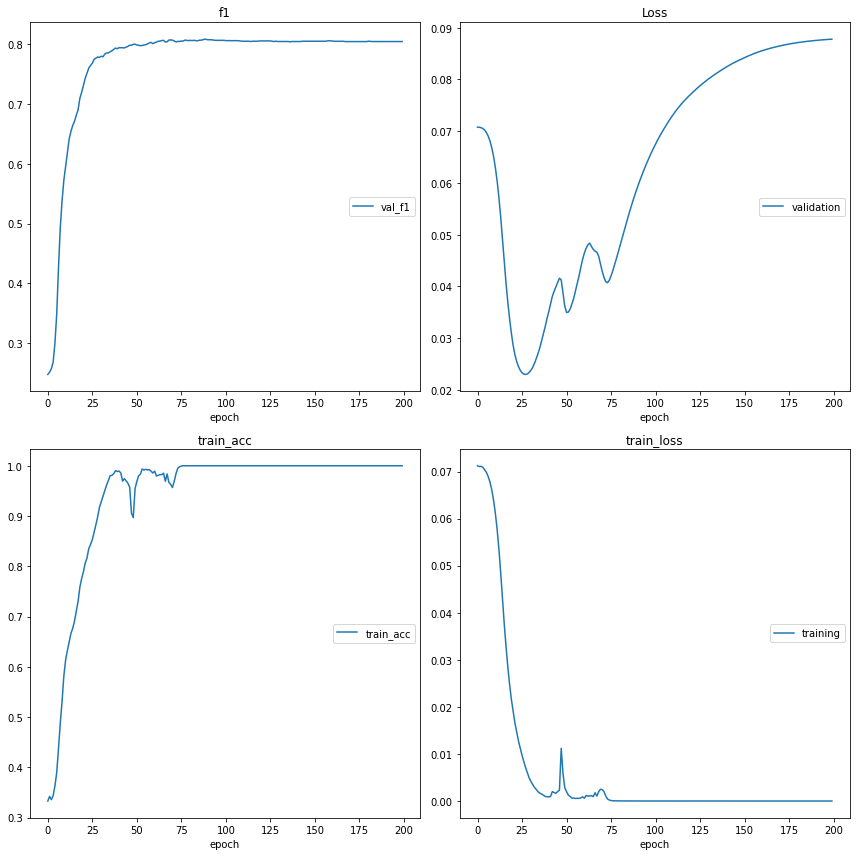

f1
	val_f1           	 (min:    0.248, max:    0.808, cur:    0.804)
Loss
	validation       	 (min:    0.023, max:    0.088, cur:    0.088)
train_acc
	train_acc        	 (min:    0.333, max:    1.000, cur:    1.000)
train_loss
	training         	 (min:    0.000, max:    0.071, cur:    0.000)


In [69]:
cfg = {'alpha': 0.41423899852781415, 'gamma': 4.605796260288279, 'noise': 0.03653895338824281, 'neurons': 2117, 'relu': 'Leaky', 'dropout1': 0.09197427109578823, 'dropout2': 0.10944076754797236, 'layers': 2}



kwargs = {"alpha": cfg['alpha'], "gamma": cfg["gamma"], "reduction": 'mean'}
criterion = kornia.losses.FocalLoss(**kwargs)

class NetDDDOptuna(nn.Module):
    def __init__(self,cfg):
        super(NetDDDOptuna, self).__init__()

        self.n = GaussianNoise(cfg['noise'])

        sz = cfg['neurons']

        if cfg['relu']=='relu':
            relu=nn.ReLU
        else:
            relu=nn.LeakyReLU


        if cfg['layers']==1:
            self.m = nn.Sequential(nn.Linear(512, sz),
                                   nn.Dropout(cfg['dropout1']),
                                   relu(),
                                   nn.Linear(sz,sz),
                                   relu(),
                                   nn.Dropout(cfg['dropout2']),
                                   nn.Linear(sz,3))

        if cfg['layers']==2:
            self.m = nn.Sequential(nn.Linear(512, sz),
                                   nn.Dropout(cfg['dropout1']),
                                   relu(),
                                   nn.Linear(sz,sz),
                                   relu(),
                                   nn.Linear(sz,sz),
                                   relu(),
                                   nn.Dropout(cfg['dropout2']),
                                   nn.Linear(sz,3))

        if cfg['layers']==3:
            self.m = nn.Sequential(nn.Linear(512, sz),
                                   nn.Dropout(cfg['dropout1']),
                                   relu(),
                                   nn.Linear(sz,sz),
                                   relu(),
                                   nn.Linear(sz,sz),
                                   relu(),
                                   nn.Linear(sz,sz),
                                   relu(),
                                   nn.Dropout(cfg['dropout2']),
                                   nn.Linear(sz,3))

    def forward(self, x):
        x = self.n(x)
        return self.m(x)
epochs = 200
batch_size = 500
train_loader = DataLoader(ds_train, batch_size=batch_size)
val_loader = DataLoader(ds_val, batch_size=batch_size)


lr = 3e-4



unique_name=datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

#     writer = torch.utils.tensorboard.SummaryWriter('./logs/pt/'+unique_name)


clip_value = 1

model = NetDDDOptuna(cfg).to(device)

for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

ema = ExponentialMovingAverage(model.parameters(), decay=0.995)
#     optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.RAdam(model.parameters(), lr=lr)
#     optimizer = AdaHessian(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=lr,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.3, div_factor=1000, final_div_factor=1000)
train_losses=[]
val_losses=[]
train_accs=[]
val_accs=[]
val_f1s = []

liveloss = PlotLosses()


for epoch in range(1, epochs + 1):
    model.train()
    train_loss=0
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()  #normal 1st order opt
#             loss.backward(create_graph=True) # adahessian
        optimizer.step()
        scheduler.step()

        ema.update()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss+=loss.item()
#     scheduler.step()
    train_loss/=len(train_loader)
    acc = correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(acc)

    model.eval()
    val_loss = 0
    correct = 0
    val_f1 = 0
    with torch.no_grad():
        with ema.average_parameters():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model.m(data)
                vl=criterion(output, target).item()
                val_loss += vl
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

                val_f1+=f1_score(target.view_as(pred).cpu(), pred.cpu(), average='weighted')


    val_loss /= float(len(val_loader))
    val_acc = correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)


    val_f1 /= float(len(val_loader))
    val_f1s.append(val_f1)

    logs={}
    logs['train_loss'] = train_loss
    logs['val_loss'] = val_loss
    logs['train_acc'] = acc
#     logs['val_acc'] = val_acc
    logs['val_f1'] = val_f1


    if val_f1>=0.825:
        print('val_f1>=0.825')
        break

    liveloss.update(logs)
    if epoch%5==0:
        liveloss.send()

In [ ]:
# # [I 2022-02-24 01:47:56,827] Trial 35 finished with value: 0.8130246066637513 and parameters: {'smoothing': 2.2731385669022297e-06, 'batch_size': 961, 'noise': 0.005599400703712527, 'neurons': 3022, 'relu': 'Leaky', 'dropout1': 0.004017445332648056, 'dropout2': 0.6251959618185807, 'lr': 0.09806801492571182}. Best is trial 35 with value: 0.8130246066637513.

# cfg ={'alpha': 0.58952085048941,
#       'gamma': 3.4880484258622437,
#       'batch_size': 5000,#488,
#       'noise': 0.06595507038359001/10,
#       'neurons': 3775,
#       'relu': 'Leaky',
#       'dropout1': 0.13587081895474534,
#       'dropout2': 0.877662163749141,
#       'lr': 0.01}#0.2811878155016364}

# # smoothing=cfg["smoothing"]
# # criterion = nn.CrossEntropyLoss(label_smoothing=smoothing)
# # criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# kwargs = {"alpha": 0.58952085048941, "gamma": 3.4880484258622437, "reduction": 'mean'}
# criterion = kornia.losses.FocalLoss(**kwargs)
# # def criterion(a,b):
# #     return kornia.losses.FocalLoss(**kwargs)(a,b) + nn.CrossEntropyLoss(label_smoothing=0.1)(a,b)


# class NetDDDOptuna(nn.Module):
#     def __init__(self,cfg):
#         super(NetDDDOptuna, self).__init__()

#         self.n = GaussianNoise(cfg['noise'])

#         sz = cfg['neurons']

#         if cfg['relu']=='relu':
#             relu=nn.ReLU
#         else:
#             relu=nn.LeakyReLU

#         self.m = nn.Sequential(nn.Linear(512, sz),
#                                    nn.Dropout(cfg['dropout1']),
#                                    relu(),
#                                    nn.Linear(sz,sz),
#                                    relu(),
# #                                    nn.Linear(sz,sz),
# #                                    relu(),
# #                                    nn.Linear(sz,sz),
# #                                    relu(),
#                                    nn.Dropout(cfg['dropout2']),
#                                    nn.Linear(sz,3))

#     def forward(self, x):
#         x = self.n(x)
#         return self.m(x)

# epochs = 200
# batch_size = cfg["batch_size"]
# train_loader = DataLoader(ds_train, batch_size=batch_size)
# val_loader = DataLoader(ds_val, batch_size=batch_size)


# noise =cfg["noise"]
# neurons = ["neurons"]
# relu = cfg["relu"]
# dropout1 = cfg["dropout1"]
# dropout2 = cfg["dropout2"]



# lr = cfg["lr"]



# unique_name=datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

# #     writer = torch.utils.tensorboard.SummaryWriter('./logs/pt/'+unique_name)


# clip_value = 1

# for xx in range(10):
#     model = NetDDDOptuna(cfg).to(device)

#     for p in model.parameters():
#         p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

#     ema = ExponentialMovingAverage(model.parameters(), decay=0.995)
# #     optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# #     optimizer = torch.optim.RAdam(model.parameters(), lr=lr)
#     optimizer = AdaHessian(model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
#                                                     max_lr=lr,
#                                                     steps_per_epoch=len(train_loader),
#                                                     epochs=epochs, pct_start=0.1, div_factor=1000, final_div_factor=1000)
#     # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5, 2)
#     # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.3, mode='triangular2',step_size_up=20)

# #     lr = lr/10


#     train_losses=[]
#     val_losses=[]
#     train_accs=[]
#     val_accs=[]
#     val_f1s = []

#     liveloss = PlotLosses()

#     for epoch in range(1, epochs + 1):
#         model.train()
#         train_loss=0
#         correct=0
#         for batch_idx, (data, target) in enumerate(train_loader):
#             data, target = data.to(device), target.to(device)
#             optimizer.zero_grad()
#             output = model(data)
#             loss = criterion(output, target)
# #             loss.backward()  #normal 1st order opt
#             loss.backward(create_graph=True) # adahessian
#             optimizer.step()
#             scheduler.step()

#             ema.update()

#             pred = output.argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()
#             train_loss+=loss.item()
#     #     scheduler.step()
#         train_loss/=len(train_loader)
#         acc = correct / len(train_loader.dataset)
#         train_losses.append(train_loss)
#         train_accs.append(acc)

#         model.eval()
#         val_loss = 0
#         correct = 0
#         val_f1 = 0
#         with torch.no_grad():
#             with ema.average_parameters():
#                 for data, target in val_loader:
#                     data, target = data.to(device), target.to(device)
#                     output = model(data)
#                     vl=criterion(output, target).item()
#                     val_loss += vl
#                     pred = output.argmax(dim=1, keepdim=True)
#                     correct += pred.eq(target.view_as(pred)).sum().item()

#                     val_f1+=f1_score(target.view_as(pred).cpu(), pred.cpu(), average='weighted')


#         val_loss /= float(len(val_loader))
#         val_acc = correct / len(val_loader.dataset)
#         val_losses.append(val_loss)
#         val_accs.append(val_acc)


#         val_f1 /= float(len(val_loader))
#         val_f1s.append(val_f1)

#         logs={}
#         logs['train_loss'] = train_loss
#         logs['val_loss'] = val_loss
#         logs['train_acc'] = acc
#     #     logs['val_acc'] = val_acc
#         logs['val_f1'] = val_f1
#         if val_f1>=0.825:
#             print('val_f1>=0.825')
#             break


#     #         # log scalars to Tensorboard
#     #         writer.add_scalar('val/f1', val_f1, epoch)
#     #         writer.add_scalar('train/loss', train_loss, epoch)
#     #         writer.add_scalar('val/loss', val_loss, epoch)

#         liveloss.update(logs)
#         if epoch%5==0:
#             liveloss.send()
    
#     if val_f1>=0.825:
#         print('val_f1>=0.825')
#         break

In [70]:
val_f1

0.8044863664160748

In [71]:
submission_embeddings = [literal_eval(embedding)  for embedding in submission['embeddings'].values]

In [72]:
x = torch.Tensor(normalize_X(submission_embeddings))
x.shape

torch.Size([3001, 512])

In [73]:
x = torch.Tensor((submission_embeddings-np.array(submission_embeddings).mean(axis=0))/np.array(submission_embeddings).std(axis=0))
x.shape

torch.Size([3001, 512])

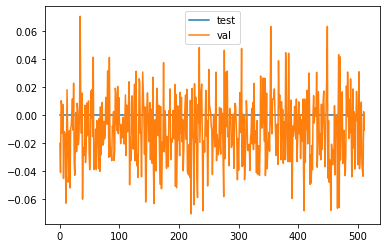

In [74]:
plt.plot(x.mean(axis=0),label='test')
plt.plot(normalize_X(X_val).mean(axis=0),label='val')
plt.legend();

In [75]:
tta = 100
results=[]
with torch.no_grad():
#     with ema.average_parameters():
    for i in range(tta):
        results.append(model.m(x.cuda()).cpu().numpy())
results = np.array(results).mean(axis=0)
print(results.shape)

(3001, 3)


In [76]:
# with torch.no_grad():
#     with ema.average_parameters():
#         result = model.m(x.cuda()).cpu()
# print(result)

In [77]:
# with ARGMAX (one hot)  MEAN STD
predictions = np.argmax(results,axis=1).tolist()

In [78]:
max(predictions)

2

In [79]:
def convert(a):
    if a==0:
        return 'negative'
    if a==1:
        return 'neutral'
    if a==2:
        return 'positive'

result = list(map(convert, predictions))

In [80]:
np.unique(result, return_counts=True)

(array(['negative', 'neutral', 'positive'], dtype='<U8'),
 array([ 963, 1050,  988]))

In [81]:
submission['label'] = result
submission

,embeddings,label
0,"[0.08109518140554428, 0.3090009093284607, 1.36...",neutral
1,"[0.6809610724449158, 1.1909409761428833, 0.892...",neutral
2,"[0.14851869642734528, 0.7872061133384705, 0.89...",neutral
3,"[0.44697386026382446, 0.36429283022880554, 0.7...",neutral
4,"[1.8009324073791504, 0.26081395149230957, 0.40...",negative
...,...,...
2996,"[0.9138844609260559, 0.9460961222648621, 0.571...",negative
2997,"[0.7667452096939087, 0.7896291613578796, 0.648...",negative
2998,"[0.8158280849456787, 2.404792070388794, 0.9924...",neutral
2999,"[0.4161085784435272, 0.3146701455116272, 1.139...",positive


### Saving the Predictions

In [82]:
# Saving the predictions
# !rm -rf assets
# !mkdir assets
submission.to_csv(os.path.join("assets", "submission.csv"))

In [83]:
%load_ext aicrowd.magic

The aicrowd.magic extension is already loaded. To reload it, use:
  %reload_ext aicrowd.magic


In [84]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/OKnOZbosE0_W0xfg60O5ImqNzi4Y69X1tYTkz5KYvNk
API Key valid
Gitlab access token valid
Saved details successfully!


In [85]:
%aicrowd notebook submit -c sentiment-classification -a assets --no-verify -n pytorch-sentiment.ipynb

An unexpected error occured!
cannot unpack non-iterable NoneType object
To get more information, you can run this command with -v.
To increase level of verbosity, you can go upto -vvvvv


Using notebook: pytorch-sentiment.ipynb for submission...
Removing existing files from submission directory...
Scrubbing API keys from the notebook...
